### Imports

In [1]:
import pandas as pd
import numpy as np
import spacy
spacy.cli.download("en_core_web_sm")
import re
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.2 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Processing

In [3]:
#restrict to records that have the same authors
# Load SBIR abstracts and patent titles
sbir_df = pd.read_csv("award_data.csv",low_memory=False)
patent_df = pd.read_csv("imported_patents.csv",low_memory=False)
nih_df = pd.read_csv("RePORTER_PRJABS_C_FY2023.csv",low_memory=False)
author_df = pd.read_csv("final.csv",low_memory=False)

In [8]:
sbir_df_filtered = sbir_df[sbir_df['PI Name'].isin(author_df['person_name'])]

In [297]:
patent_df['inventor_list'] = patent_df['inventor'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").split(", "))
patent_df = patent_df.explode('inventor_list')

In [305]:
patent_df_filtered = patent_df[patent_df['inventor_list'].isin(author_df['person_name'])]

In [309]:
# Load NLP model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """Lowercase, remove special characters, and lemmatize text."""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

# Apply preprocessing
sbir_df_filtered["clean_abstract"] = sbir_df_filtered["Abstract"].astype(str).apply(preprocess_text)
patent_df_filtered["clean_title"] = patent_df_filtered["invention_title"].astype(str).apply(preprocess_text)

/var/folders/xy/fxqbz57d3jv2cs65m5slsrf00000gn/T/ipykernel_41353/3434805734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbir_df_filtered["clean_abstract"] = sbir_df_filtered["Abstract"].astype(str).apply(preprocess_text)
/var/folders/xy/fxqbz57d3jv2cs65m5slsrf00000gn/T/ipykernel_41353/3434805734.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patent_df_filtered["clean_title"] = patent_df_filtered["invention_title"].astype(str).apply(preprocess_text)


## Similarity Calculation

In [310]:
import torch
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings (shape: [len(df), 384])
sbir_embeddings = model.encode(sbir_df_filtered["clean_abstract"].tolist(), convert_to_tensor=True)
patent_embeddings = model.encode(patent_df_filtered["clean_title"].tolist(), convert_to_tensor=True)

# Normalize embeddings to unit vectors
sbir_embeddings = torch.nn.functional.normalize(sbir_embeddings, p=2, dim=1)
patent_embeddings = torch.nn.functional.normalize(patent_embeddings, p=2, dim=1)

# Compute pairwise cosine similarity
sbir_patent_cosine = torch.mm(sbir_embeddings, patent_embeddings.T)  # (100, 100)

# Convert to numpy for easier processing
# sbir_nih_scores = sbir_nih_cosine.cpu().numpy()
sbir_patent_scores = sbir_patent_cosine.cpu().numpy()
# patent_nih_scores = patent_nih_cosine.cpu().numpy()

print("Pairwise similarity calculations complete!")


Pairwise similarity calculations complete!


In [422]:
sbir_patent_scores = sbir_patent_cosine.cpu().numpy()

#get rid of perfect matches, they are errors (both null)
filt_df = sbir_patent_scores
filt_df[filt_df > 1] = 0
# Find the maximum value
max_value = np.max(filt_df)

# Find the index of the maximum value
max_index = np.unravel_index(np.argmax(filt_df), filt_df.shape)

print("Maximum Value:", max_value)
print("Index of Maximum Value:", max_index)


Maximum Value: 0.7713935
Index of Maximum Value: (3405, 5909)


In [426]:
# Find details of best match

print("sbir abstract: "+str(sbir_df_filtered.iloc[max_index[0]]['Abstract']))
print("sbir PI: "+str(sbir_df_filtered.iloc[max_index[0]]['PI Name']))
print("patent title: "+str(patent_df_filtered.iloc[max_index[1]]['invention_title']))
print("patent inventor: "+str(patent_df_filtered.iloc[max_index[1]]['inventor']))

sbir abstract: LM Group Holdings Inc. (LMGH) partnering with Fabrisonic LLC is proposing a program to investigate manufacturing of amorphous metal alloy laminate composites and cladding of metallic surfaces by using ultrasonic additive manufacturing (UAM), a solid-state 3D metal printing technology.nbsp;
sbir PI: Evelina Vogli
patent title: ['Ultrasonic additive manufacturing of cladded amorphous metal products']
patent inventor: ['Evelina Vogli, John Kang, Ricardo Salas, Adam Hehr']


In [412]:
for col in patent_df_filtered.iloc[max_index[1]][['applicant_organization','invention_title','inventor']]:
    print(col)

['CROSSLIFE TECHNOLOGIES INC.]']
['Rapid nucleic acid detection without sample preparation']
['HyunDae Cho, Yuanyuan Wu, Jarred Yasuhara-Bell']


## Plotting

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


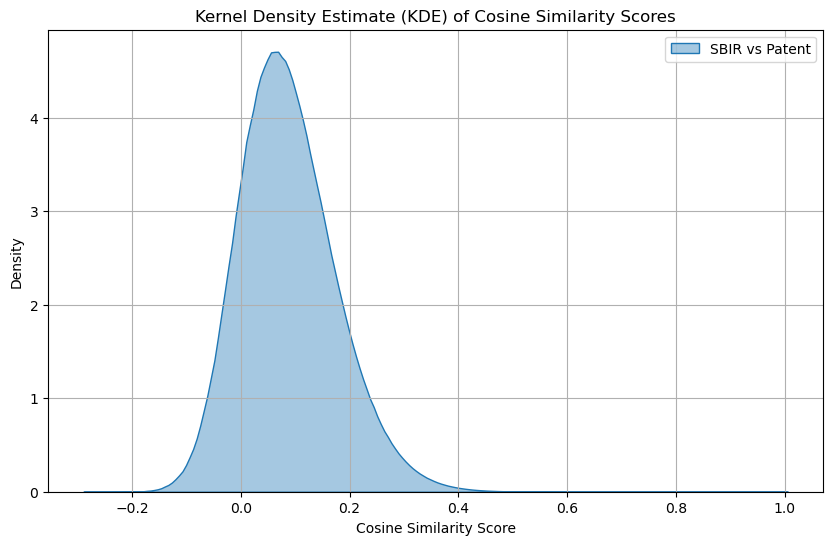

In [311]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten similarity matrices to 1D arrays
# sbir_nih_flat = sbir_nih_scores.flatten()
sbir_patent_flat = sbir_patent_scores.flatten()
# patent_nih_flat = patent_nih_scores.flatten()

# Plot KDE for each similarity matrix
plt.figure(figsize=(10, 6))
# sns.kdeplot(sbir_nih_flat, label="SBIR vs NIH", fill=True, alpha=0.4)
sns.kdeplot(sbir_patent_flat, label="SBIR vs Patent", fill=True, alpha=0.4)
# sns.kdeplot(patent_nih_flat, label="Patent vs NIH", fill=True, alpha=0.4)

# Customize plot
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Density")
plt.title("Kernel Density Estimate (KDE) of Cosine Similarity Scores")
plt.legend()
plt.grid()
# plt.save_fig()
# Show plot
plt.show()


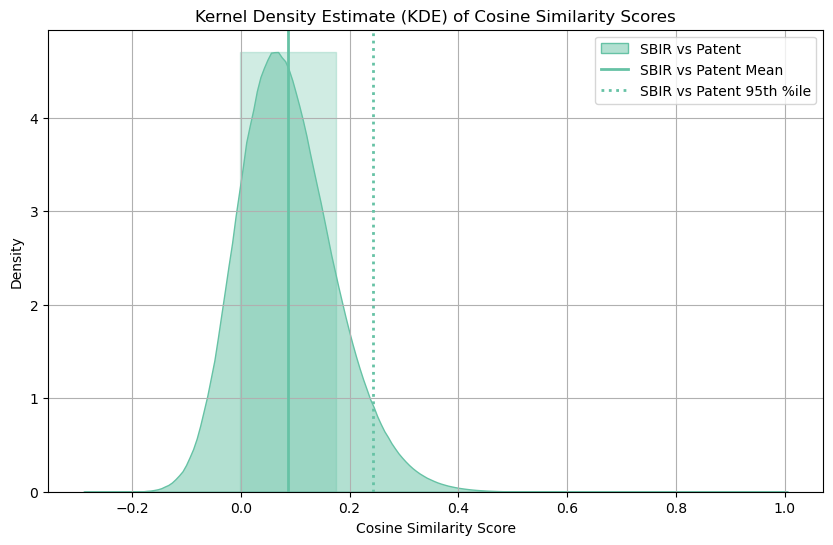

In [322]:
from scipy.stats import gaussian_kde

# Flatten similarity matrix to 1D array
sbir_patent_flat = sbir_patent_scores.flatten()

datasets = {
    "SBIR vs Patent": sbir_patent_flat,
}

# Plot KDE
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", n_colors=len(datasets))  # Get unique colors for each dataset

for (label, data), color in zip(datasets.items(), colors):
    mean_val = np.mean(data)
    std_val = np.std(data)
    perc_95 = np.percentile(data, 95)

    # KDE plot
    sns.kdeplot(data, label=label, fill=True, alpha=0.5, color=color)

    # Solid vertical line at mean
    plt.axvline(mean_val, color=color, linestyle='-', linewidth=2, label=f"{label} Mean")

    # Compute KDE for shading standard deviation
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 100)
    y_vals = kde(x_vals)  # Compute KDE density estimates
    max_y = max(y_vals)  # Maximum KDE value for shading

    # Shaded region for standard deviation
    plt.fill_betweenx(
        y=np.linspace(0, max_y, 100),
        x1=mean_val - std_val, x2=mean_val + std_val, 
        color=color, alpha=0.3
    )

    # Dotted vertical line at 95th percentile
    plt.axvline(perc_95, color=color, linestyle='dotted', linewidth=2, label=f"{label} 95th %ile")

# Customize plot
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Density")
plt.title("Kernel Density Estimate (KDE) of Cosine Similarity Scores")
plt.legend()
plt.grid()
plt.savefig("sbir_vs_patent_cosine.png", format="png", bbox_inches="tight")

# Show plot
plt.show()


In [324]:
perc_95

0.24331830441951752

### Put results into dataframe to allow for individual match result checking

In [445]:
# Example similarity matrix (num_awards x num_patents)
# Replace this with your actual numpy array
similarity_matrix = sbir_patent_scores  # 100 SBIR Awards, 200 Patents

# Dummy award IDs and patent IDs (replace with actual IDs)
sbir_award_ids = sbir_df_filtered['Agency Tracking Number']
patent_ids = patent_df_filtered['publication_doc_number']

# Convert to a DataFrame
similarity_data = []
for i, award_id in enumerate(sbir_award_ids):
    for j, patent_id in enumerate(patent_ids):
        similarity_data.append([award_id, patent_id, similarity_matrix[i, j]])

df = pd.DataFrame(similarity_data, columns=["award_id", "patent_id", "similarity_score"])

# Save as CSV
# df.to_csv("/mnt/data/similarity_scores.csv", index=False)
df

,award_id,patent_id,similarity_score
0,24.1 DHS241-001-0020-I,['D0974097'],0.000106
1,24.1 DHS241-001-0020-I,['11540723'],0.203773
2,24.1 DHS241-001-0020-I,['11540730'],0.325858
3,24.1 DHS241-001-0020-I,['11540735'],0.324556
4,24.1 DHS241-001-0020-I,['11540751'],0.206094
...,...,...,...
188060452,563,['11710662'],0.049524
188060453,563,['11710679'],0.107258
188060454,563,['11710748'],0.001483
188060455,563,['11710764'],-0.019910


In [458]:
# How many scores above 0.6?
df[df['similarity_score']>0.6].to_csv('similarity_sbir_patent.csv',index=False)

,award_id,patent_id,similarity_score
258465,N231-031-0402,['11628917'],0.609919
260672,N231-031-0402,['D0987566'],0.604869
543721,FX235-CSO1-1100,['11604368'],0.603638
544826,FX235-CSO1-1100,['11619871'],0.612004
545192,FX235-CSO1-1100,['11624967'],0.607997
...,...,...,...
181838644,NASA376,['11708045'],0.670646
183351497,N981-0054,['11673353'],0.625351
183351498,N981-0054,['11673353'],0.625351
187859850,21072,['11630223'],0.633167


### Patent data chunking to help Neo4j Upload

In [88]:
chunk_size = 10000  # Number of rows per file

# Split the dataframe and save each chunk as a CSV file
for i, chunk in enumerate(range(0, len(patent_df), chunk_size)):
    chunk_df = patent_df.iloc[chunk:chunk + chunk_size]
    chunk_df.to_csv(f'patent_chunk_{i+1}.csv', index=False)
    
print("Splitting complete!")


Splitting complete!
